# Experiment on a reduced version of the Food-101 dataset

Due to the large size of the dataset, some experiment has been done reducing the number of classes to 3 speeding up training.

## Downloading the data

The dataset is retrieved from the website http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz using as a reference the following research paper


> Lukas Bossard, Matthieu Guillaumin, Luc Van Gool - Food-101 – Mining Discriminative Components with Random Forests

The Food-101 data set consists of images from Foodspotting [1]. Any use beyond
   scientific fair use must be negociated with the respective picture owners
   according to the Foodspotting terms of use [2].

[1] http://www.foodspotting.com/
[2] http://www.foodspotting.com/terms/

In [1]:
#importing essential modules
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
from os import path
import time
from random import seed, choice

In [ ]:
#the data will be downloaded and automatically extracted to the data folder ../data/food-101/images
%mkdir data
!wget -O ../data/food-101.tar.gz http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -zxf ../data/food-101.tar.gz -C data

In [2]:
#loading metadata
metafolder = "../data/food-101/meta/"
train_meta = pd.read_json(path_or_buf = metafolder + "train.json")
test_meta = pd.read_json(path_or_buf = metafolder + "test.json")

> ### Organising metdatada for training, testing and validation

In [3]:
#organising metadata for training, testing and validation
validation_split = 0.2
val_split_idx = int(np.floor(train_meta.shape[0]*validation_split))

#folder with all the food images
data_dir = "../data/food-101/images/"
folders_sorted = sorted(os.listdir(data_dir))

#number of categories to randomly select
nc = 101

#selecting a randomn subset of categories
seed(42)

selection = []
while len(selection) < nc:
    pick = choice(folders_sorted)
    if pick not in set(selection):
        selection.append(pick)
        
print("Selected categories : {}".format(', '.join(map(str, selection))))

Selected categories : ramen, carrot_cake, beef_carpaccio, strawberry_shortcake, escargots, donuts, croque_madame, cheesecake, caprese_salad, sashimi, oysters, caesar_salad, pho, hot_and_sour_soup, beef_tartare, creme_brulee, cup_cakes, miso_soup, pork_chop, paella, club_sandwich, spaghetti_carbonara, red_velvet_cake, shrimp_and_grits, hamburger, hummus, apple_pie, takoyaki, chicken_wings, fried_calamari, chicken_quesadilla, greek_salad, cannoli, frozen_yogurt, fried_rice, edamame, beet_salad, steak, ice_cream, onion_rings, ceviche, bruschetta, pad_thai, filet_mignon, pulled_pork_sandwich, prime_rib, garlic_bread, panna_cotta, clam_chowder, spaghetti_bolognese, bread_pudding, risotto, tiramisu, gnocchi, crab_cakes, samosa, eggs_benedict, scallops, ravioli, breakfast_burrito, chocolate_cake, lasagna, seaweed_salad, french_onion_soup, tuna_tartare, bibimbap, french_fries, guacamole, pancakes, macarons, grilled_salmon, chicken_curry, sushi, peking_duck, mussels, tacos, beignets, pizza, gri

In [4]:
train_meta = train_meta[selection].iloc[:train_meta.shape[0] - val_split_idx]

valid_meta = train_meta[selection].iloc[train_meta.shape[0] - val_split_idx:]

test_meta = test_meta[selection]

#Setting train, validation and test set target folder
#target folder - train
trainfolder = "../data/food-101/train_img/"

#target folder - validation
validfolder = "../data/food-101/valid_img/"

#target folder -test
testfolder = "../data/food-101/test_img/"

print("{} images used for training".format(train_meta.shape[0]*train_meta.shape[1]))
print("{} images used for validation".format(valid_meta.shape[0]*valid_meta.shape[1]))
print("{} images used for testing".format(test_meta.shape[0]*test_meta.shape[1]))

60600 images used for training
15150 images used for validation
25250 images used for testing


In [9]:
#dividing into train and test set using the json metadata 

def organise_files_from_df(df, datafolder, datatarget):
    """
    This function moves files contained in a folder (datafolder) to a target path (datatarget),
    based on the information contained on a dataframe (df) where each column corresponds to a 
    class name (sub-folder). Every column of the dataset contains a list of filenames to be moved.
    """
    
    #creating target folder
    if not path.exists(datatarget):
        os.mkdir(datatarget)
    
    #iterating through dataframe columns ( =  labels)
    for label in list(df.columns):
        
        #create folder
        foldername = datatarget + str(label)
        
        if not path.exists(foldername):
            os.mkdir(foldername)
        
        #move each file
        for file in list(df[label]):
            
            fileoriginal =  datafolder + file + ".jpg"
            filetarget = datatarget +"/" + file + ".jpg"
            
            try:
                if not path.exists(filetarget):
                    shutil.copyfile(fileoriginal, filetarget)

            except FileNotFoundError:
                print("File {} not found!".format(file))
                pass

#origin folder
imagefolder = "../data/food-101/images/"


organise_files_from_df(train_meta, imagefolder, trainfolder)


organise_files_from_df(valid_meta, imagefolder, validfolder)

organise_files_from_df(test_meta, imagefolder, testfolder)

#to delete the origin folder, uncomment the line below
#shutil.rmtree(imagefolder)

> ### Visualise the data

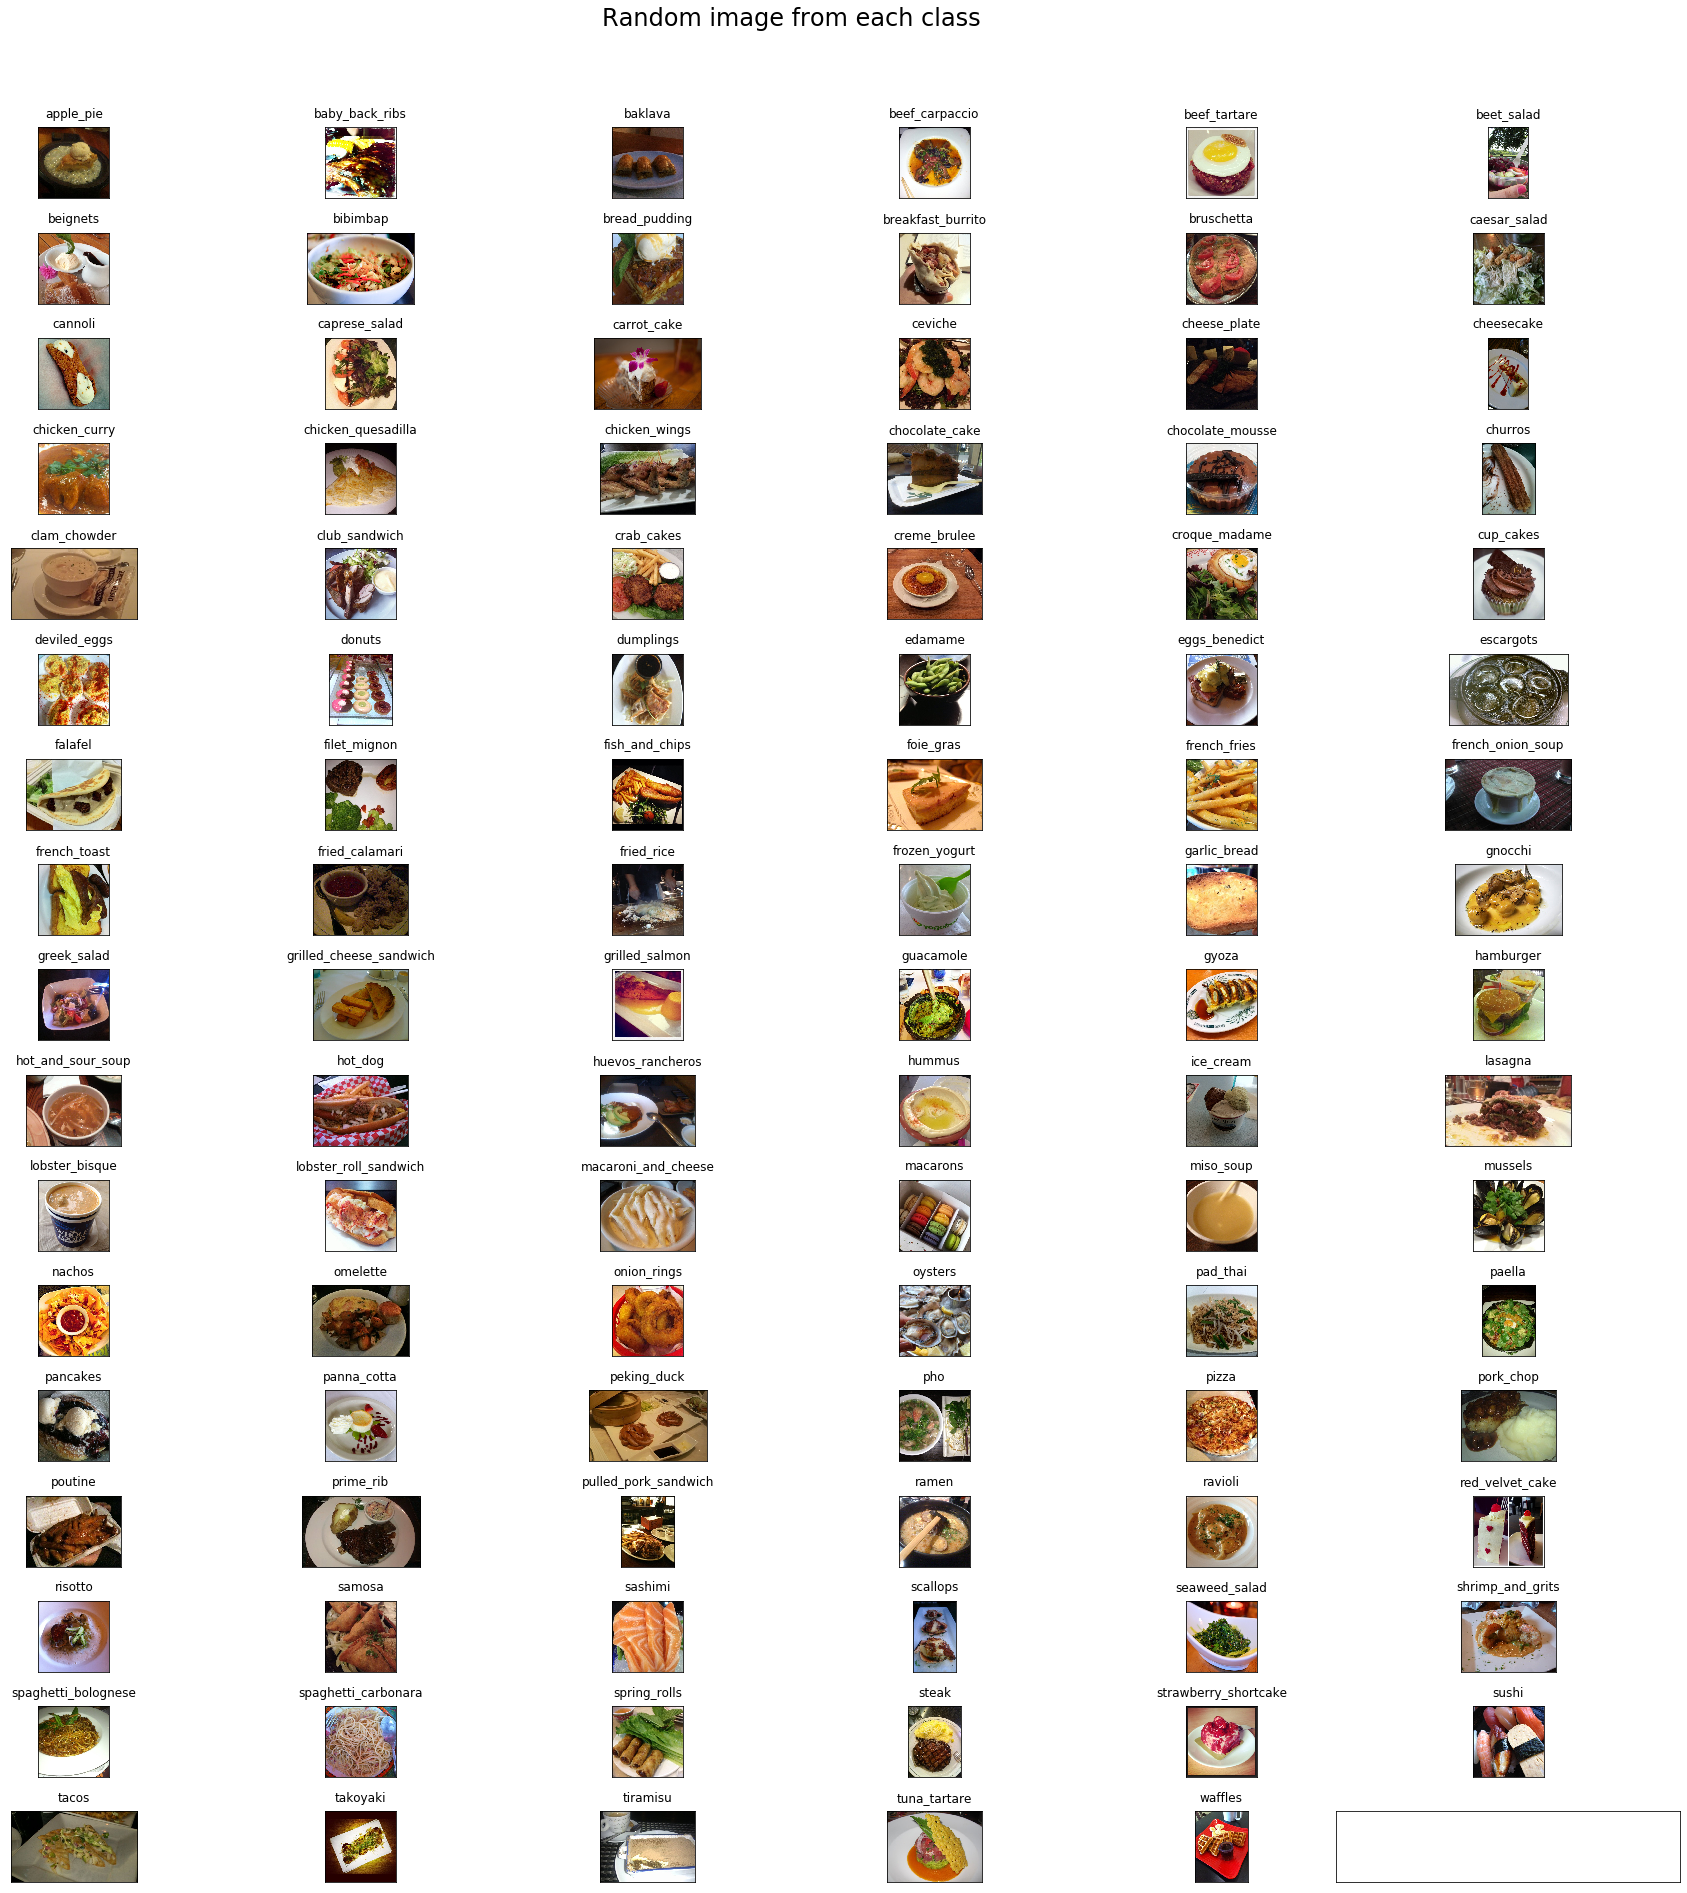

In [5]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6

fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Random image from each class", y=1.05, fontsize=24) 

fold_id = 0

for i in range(rows):
    for j in range(cols):
        try:
            fold_selected = folders_sorted[fold_id] 
            fold_id += 1
        except:
            break
        if fold_selected == '.DS_Store':
            continue
        
        food_selected_img = os.listdir(os.path.join(data_dir,fold_selected)) # list of all files present in each food folder
        food_selected_random = np.random.choice(food_selected_img) # picks one food item from the list as choice, takes a list and returns one random item
    
        img = plt.imread(os.path.join(data_dir, fold_selected, food_selected_random))
    
        ax[i][j].imshow(img)
        ax[i][j].set_title(fold_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

> ### Transformers set-up for train, validation and test data

In [5]:
#Norm values
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

#Img size parameters
img_short_side_resize = 256
img_input_size = 224

import os
from torchvision import datasets
import torchvision.transforms as transforms


transform_train = transforms.Compose([
                    transforms.Resize(img_short_side_resize),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio=(1,1)), 
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])
transform_test = transforms.Compose([
                    transforms.Resize(img_input_size),  
                    transforms.FiveCrop(img_input_size),
                    transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops]))])

train_data = datasets.ImageFolder(trainfolder, transform_train)
valid_data = datasets.ImageFolder(validfolder, transform_test)
test_data = datasets.ImageFolder(testfolder, transform_test)

> ### Data loaders

In [6]:
import torch

shuffle = True
num_workers = 16
batch_size = 64

# Create the data loaders
data = {"train" : train_data, "val":valid_data, "test" : test_data}

train_loader = torch.utils.data.DataLoader(data["train"], batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, pin_memory=True)

#### --- NOTE on num_workers if using 5crop and batch_size for testing --- ###
# If using the 5crop test time augmentation, num_workers = 0 (an error is raised otherwise) 
# batch_size needs to be reduced during testing due to memory requirements
valid_loader = torch.utils.data.DataLoader(data["val"], batch_size=int(np.floor(batch_size/5)), num_workers=0, shuffle=shuffle, pin_memory=True)

test_loader = torch.utils.data.DataLoader(data["test"], batch_size=int(np.floor(batch_size/5)), num_workers=0, shuffle=shuffle, pin_memory=True)
loaders_transfer = {"train" : train_loader, "val":valid_loader, "test" : test_loader}

> ### CPU vs GPU 

In [7]:
#setting CPU vs GPU

use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
    print("Using",torch.cuda.get_device_name(device))

CUDA is available!  Training on GPU ...
Using GeForce GTX 960M


> ### Loading pre-trained ResNet for transfer learning
- slice off the end of the neural network
- add a new fully connected layer that matches the number of classes in the new data set
- randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
- train the network to update the weights of the new fully connected layer

In [8]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet50(pretrained=True)

#freezing the parameters
for param in model_transfer.parameters():
    param.requires_grad = False
    
n_classes = len(train_data.classes)

# Replacing the last layer with a fully connected layer to retrain
model_transfer.fc = nn.Linear(model_transfer.fc.in_features,n_classes)

# Initialize the weights of the new layer
nn.init.kaiming_normal_(model_transfer.fc.weight, nonlinearity='relu')

# Transfer to GPU 
model_transfer = model_transfer.to(device)

> ### Loss function and optimizer

In [9]:
#specify loss function and optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(),3e-4) 
scheduler_transfer = ReduceLROnPlateau(optimizer_transfer, 'min', verbose = True, factor = 0.5, patience = 7)

> ### Training function implementation

In [10]:
import time
import datetime

def train_epoch(model,train_loader,optimizer,criterion,device):
    """
    train steps at each epoch
    """
    train_loss = 0.0
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device) # move to GPU
        
        optimizer.zero_grad() # set gradients to 0
        
        output = model(data) # get output
        
        loss = criterion(output, target) # calculate loss
        train_loss += loss.item() * data.size(0)
        
        loss.backward() # calculate gradients
        
        optimizer.step() # take step
        
    train_loss = train_loss / len(train_loader.dataset)
    return model, train_loss
        
def valid_epoch(model, valid_loader, criterion, device, fivecrop):
    """
    validation prediction steps at each epoch
    """
    valid_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for data, target in valid_loader:
            
            data, target = data.to(device), target.to(device) # move to GPU
            
            # if we do test time augmentation with 5crop we'll have an extra dimension in our tensor
            if fivecrop == "mean":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).mean(1)
            elif fivecrop == "max":
                bs, ncrops, c, h, w = data.size()
                output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
                output = output.view(bs, ncrops, -1).max(1)[0]
            else:
                output = model(data)
                
            ## update the average validation loss
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            
    valid_loss = valid_loss / len(valid_loader.dataset) 
    return valid_loss


def train(n_epochs, loaders, model, optimizer, criterion, device, path_model, fivecrop = None, lr_scheduler = None, valid_loss_min = np.Inf, start_epoch=1, train_loss = [], valid_loss = []):
    """
    model training
    """
     
    time_start = time.time()
    best_epoch = start_epoch
    
    for epoch in range(start_epoch, start_epoch + n_epochs):
        
        time_start_epoch = time.time()  
        
        # train current epoch
        model, train_loss_epoch = train_epoch(model,loaders["train"],optimizer,criterion,device) 
        train_loss.append(train_loss_epoch)   
        
        # validate current epoch
        valid_loss_epoch = valid_epoch(model,loaders["val"],criterion,device,fivecrop)
        
        # learning rate scheduler
        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss_epoch)
        valid_loss.append(valid_loss_epoch)  
        
        is_best = False
        
        if valid_loss_epoch <= valid_loss_min: # save if validation loss is the lowest so far
            torch.save(model.state_dict(), path_model)
            valid_loss_min = valid_loss_epoch 
            best_epoch = epoch
            is_best = True
            
        #epoch time tracker
        minutes_past_epoch = (time.time() - time_start_epoch)//60
        seconds_spare_epoch = round((time.time() - time_start_epoch)%60)
        currentDT = datetime.datetime.now()
        exact_time =  str(currentDT.hour) + ":" + str(currentDT.minute) + ":" + str(currentDT.second)
        
        # print epoch stats
        print('Epoch {} done in {} minutes and {} seconds at {}. \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format( 
            epoch,             
            minutes_past_epoch,
            seconds_spare_epoch,
            exact_time,
            train_loss_epoch,
            valid_loss_epoch
            ))    
        
        #save the best model status for resuming training
        model_status = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_loss_min': min(train_loss),
                'valid_loss_min': valid_loss_min,
                'is_best': is_best}

        if lr_scheduler is not None:
            model_status['scheduler'] = lr_scheduler.state_dict()
        
        if is_best:
            print("Best validation results so far - saving best model in {}".format(path_model + "_best.tar"))
            torch.save(model_status, path_model + ".tar") #saving resume training model data
            torch.save(model_status, path_model.replace(".pt", "") + "_best.pt.tar") #saving best model data
        else:
            if train_loss_epoch <= min(train_loss):
                torch.save(model_status, path_model + ".tar") #saving resume training model data
            else:
                print("Last epoch was not saved in {} since both validation and training loss didn't improve.")
            
        
    #total time tracker
    minutes_past = (time.time() - time_start)//60
    hours_past = minutes_past//60
    minutes_spare = minutes_past%60
    seconds_spare = round((time.time() - time_start)%60)
        
    # print final statistics    
    print(f"{n_epochs} epochs trained in {hours_past} hours, {minutes_spare} minutes and {seconds_spare} seconds. ") 
    
    print("Best model obtained at epoch {} with minimum validation loss : {:.3f}".format(best_epoch, valid_loss_min)) 
    
    # Load best config
    model.load_state_dict(torch.load(path_model))
    
    return model

> ## Training

In [11]:
# train the model
n_epochs = 3

model_transfer = train(n_epochs, 
                       loaders_transfer, 
                       model_transfer, 
                       optimizer_transfer, 
                       criterion_transfer, 
                       device, 
                       'models/model_res_{}cat.pt'.format(nc), 
                       fivecrop = "mean", 
                       lr_scheduler = scheduler_transfer)

Epoch 1 done in 2390.76 seconds at 20:49:53. 	Training Loss: 3.385 	Validation Loss: 2.363
Epoch 2 done in 2530.60 seconds at 21:32:4. 	Training Loss: 2.595 	Validation Loss: 2.037
Epoch 3 done in 2520.86 seconds at 22:14:5. 	Training Loss: 2.406 	Validation Loss: 1.880
3 epochs trained in 7443.216 seconds. 
Best model obtained at epoch 3 with minimum validation loss : 1.880


> ### Testing function implementation

In [18]:
def test(loaders, model, criterion, device):
    """
    test function
    """
    
    test_loss = 0.
    correct = 0.
    total = 0.
    
    model.eval()
    
    with torch.no_grad():
        
        for batch_idx, (data, target) in enumerate(loaders['test']):
            
            data, target = data.to(device), target.to(device) # move to GPU
            
            bs, ncrops, c, h, w = data.size()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
            output = output.view(bs, ncrops, -1).mean(1)    
            
            loss = criterion(output, target) # calculate the loss
            
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss)) # update average test loss 
            
            pred = output.data.max(1, keepdim=True)[1] # convert output probabilities to predicted class
            
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()) 
            total += data.size(0)            
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

> ## Testing

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, device)

Test Loss: 0.378300


Test Accuracy: 87% (2183/2500)
